<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">ASSO: Advanced Salp Swarm Optimizer</h1> 
    <h2 style="color:#483D8B;text-align:center;">Analysis of the results</h2>
    <br>25 February 2021 @ UniBG
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Senior Postdoc – University of Bergamo<br>
    Department of Human and Social Sciences<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Piazzale S. Agostino 2,<br>
        24129, Bergamo, Italy<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:andrea.tangherloni@unibg.it">andrea.tangherloni@unibg.it</a> <br>
        <span style="color:#483D8B;"><b>Website:</b></span>
            <a href="https://www.andreatangherloni.com">www.andreatangherloni.com</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from statannot import add_stat_annotation

from matplotlib import cm

In [3]:
# ****************************************************** Ackley *******************************************************
def Ackley_shifted(x, a=20, b=0.2, c=2*math.pi, shift=1e6):

    D = len(x)

    accum1  = 0.0
    for i in range(D):
        accum1 += (x[i] - shift)**2	
    accum1 = accum1 / D

    accum2  = 0.0
    for i in range(D):
        accum2 += math.cos(c * (x[i] - shift))
    accum2 = accum2 / D

    accum = - a * math.exp(-b * math.sqrt(accum1)) - math.exp(accum2) + a + math.exp(1)

    return accum


# ****************************************************** Alpine *******************************************************
def Alpine_shifted(x, shift=1e6):

    D = len(x)

    accum = 0.0
    for i in range(D):
        accum += math.fabs((x[i] - shift) * math.sin(x[i] - shift) + 0.1 * (x[i] - shift))
    return accum


# **************************************************** Rosenbrock *****************************************************
def Rosenbrock_shifted(x, shift=1e6):

    D = len(x)

    accum = 0.0
    for i in range(D-1):
        accum += (100.0 * ((x[i+1] - shift) - (x[i] - shift)**2)**2 + ((x[i] - shift) - 1)**2)

    return accum


# ****************************************************** Sphere *******************************************************
def Sphere_shifted(x, shift=1e6):

    D = len(x)

    accum = 0.0
    for i in range(D):
        accum += (x[i] - shift)**2

    return accum


# **************************************************** Boundaries *****************************************************
def Boundaries(name, shift=1e6, shrink=1e-20):

    limits = {}

    limits["Ackley_shifted"]     = [-32.768 + shift, 32.768 + shift]
    limits["Alpine_shifted"]     = [-10     + shift, 10     + shift]
    limits["Rosenbrock_shifted"] = [-5      + shift, 10     + shift]
    limits["Sphere_shifted"]     = [-5.12   + shift, 5.12   + shift]

    return limits[name]

In [4]:
from itertools import combinations

def multipleComparisons(dataframe,
                        group_by     = None,
                        data         = None,
                        test         = "Mann–Whitney U test",
                        correction   = "bonferroni",
                        alpha        = 0.05, 
                        verbose      = True,
                        min_elements = 20,
                        **kwargs):
    
    tests       = ["Mann–Whitney U test", "Wilcoxon paired test", "Wilcoxon test", "t-test paired",
                   "t-test independent", "Welch's t-test", "Kruskal-Wallis test",
                   "Anderson-Darling test", "Kolmogorov-Smirnov test"]
    corrections = [None, 'bonferroni', 'sidak', 'holm-sidak', 'holm', 'simes-hochberg', 'hommel',
                   'fdr_bh', 'fdr_by', 'fdr_tsbh', 'fdr_tsbky']
    toExit      = False
    
    if group_by is None:
        print("'group_by' can not be equal to None. Please provide one of the columns")
        toExit = True
    elif group_by not in dataframe.columns:
        print("'group_by'=''%s' is not one of the columns. Please provide one among:"%group_by, "|".join(dataframe.columns))
        toExit = True
    
    if data is None:
        print("'data' can not be equal to None. Please provide one of the columns")
        toExit = True
    
    elif data not in dataframe.columns:
        print("'data'='%s' is not one of the columns. Please provide one among:"%data, "|".join(dataframe.columns))
        toExit = True
        
    if test not in tests:
        print("'test'='%s' is not one of the possible tests. Please provide one among:"%test, "|".join(tests))
        toExit = True
        
    if correction not in corrections:
        print("'correction'='%s' is not one of the possible corrections. Please provide one among:"%correction, "|".join(corrections))
        print("'bonferroni'     : one-step correction")
        print("'sidak'          : one-step correction")
        print("'holm-sidak'     : step down method using Sidak adjustments")
        print("'holm'           : step-down method using Bonferroni adjustments")
        print("'simes-hochberg' : step-up method (independent)")
        print("'hommel'         : closed method based on Simes tests (non-negative)")
        print("'fdr_bh'         : Benjamini/Hochberg (non-negative)")
        print("'fdr_by'         : Benjamini/Yekutieli (negative)")
        print("'fdr_tsbh'       : two stage fdr correction (non-negative)")
        print("'fdr_tsbky'      : two stage fdr correction (non-negative)")
        
        toExit = True
        
    if alpha < 0 and alpha > 1:
        print("'alpha'='%d' is not valid. Please provide a value in the range [0,1]"%alpha)
        toExit = True
    
    if toExit:
        return None
    
    dataframe[group_by] = dataframe[group_by].astype('category')
    
    combs = list(combinations(dataframe[group_by].cat.categories, 2))
    
    results = pd.DataFrame(columns = ["Group 1","Group 2", "p-value", "corrected p-value"],
                           index   = list(range(len(combs))))
    
    # ******************************************* Mann–Whitney U test *******************************************
    if test=="Mann–Whitney U test":
        print("* Running 'Mann–Whitney U test' ('scipy.stats.mannwhitneyu')")
        from scipy.stats import mannwhitneyu

        use_continuity = True
        alternative    = None
        
        if "use_continuity" in kwargs.keys() and kwargs["use_continuity"] in [True, False]:
            use_continuity = kwargs["use_continuity"]
        if "alternative" in kwargs.keys() and kwargs["alternative"] in [None, 'two-sided', 'less', 'greater']:
            alternative = kwargs["alternative"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = mannwhitneyu(g0,
                                       g1,
                                       use_continuity = use_continuity,
                                       alternative    = alternative)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval

    
    # ******************************************* Wilcoxon paired test *******************************************
    elif test=="Wilcoxon paired test":
        
        if verbose:
            print("* Running 'Wilcoxon paired test' ('scipy.stats.wilcoxon')")
            
        from scipy.stats import wilcoxon

        zero_method = 'wilcox'
        correction  = False
        alternative = 'two-sided'
        mode        = 'auto'
        
        if "zero_method" in kwargs.keys() and kwargs["zero_method"] in ['pratt', 'wilcox', 'zsplit']:
            zero_method = kwargs["zero_method"]
        if "correction" in kwargs.keys() and kwargs["correction"] in [True, False]:
            correction = kwargs["correction"]
        if "alternative" in kwargs.keys() and kwargs["alternative"] in ['two-sided', 'less', 'greater']:
            alternative = kwargs["alternative"]
        if "mode" in kwargs.keys() and kwargs["mode"] in ['auto', 'exact', 'approx']:
            mode = kwargs["mode"]
       
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
            
            if len(g0) != len(g1):
                print("The samples '%s' and '%s' must have the same length"%(comb[0],comb[1]))
                return None
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = wilcoxon(dataframe[dataframe[group_by]==comb[0]][data],
                                   dataframe[dataframe[group_by]==comb[1]][data],
                                   zero_method = zero_method,
                                   correction  = correction,
                                   alternative = alternative,
                                   mode        = mode)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
    
    
    # ******************************************* Wilcoxon test *******************************************
    elif test=="Wilcoxon test":    
        if verbose:
            print("* Running 'Wilcoxon test' ('scipy.stats.ranksums')")
            
        from scipy.stats import ranksums
              
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = ranksums(g0,g1)

            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
    
    
    # ******************************************* Wilcoxon paired test *******************************************
    elif test=="t-test paired":
        if verbose:
            print("* Running 't-test paired' ('scipy.stats.ttest_rel')")
            
        from scipy.stats import ttest_rel

        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if len(g0) != len(g1):
                print("The samples '%s' and '%s' must have the same length"%(comb[0],comb[1]))
                return None
            
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = ttest_rel(g0,
                                    g1,
                                    nan_policy = nan_policy)
                                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            
            
    # ******************************************* t-test independent *******************************************
    elif test=="t-test independent":
        if verbose:
            print("* Running 't-test independent' ('scipy.stats.ttest_ind')")
            
        from scipy.stats import ttest_ind
        
        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
            
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:  
                _, pval = ttest_ind(g0,
                                    g1,
                                    equal_var  = True,
                                    nan_policy = nan_policy)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
    
    
    # ******************************************* Welch's t-test *******************************************
    elif test=="Welch's t-test":
        
        if verbose:
            print("* Running 'Welch's t-test' ('scipy.stats.ttest_ind with equal_var=False')")
            
        from scipy.stats import ttest_ind
        
        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:
                _, pval = ttest_ind(g0,
                                    g1,
                                    equal_var  = False,
                                    nan_policy = nan_policy)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            
    # ******************************************* Kruskal-Wallis test *******************************************
    elif test=="Kruskal-Wallis test":
        
        if verbose:
            print("* Running 'Kruskal-Wallis test' ('scipy.stats.kruskal')")
            
        from scipy.stats import kruskal
        
        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = kruskal(g0,
                                  g1,
                                  nan_policy = nan_policy)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval

            
    # ******************************************* Anderson-Darling test *******************************************
    elif test=="Anderson-Darling test":
        
        if verbose:
            print("* Running 'Anderson-Darling test' ('scipy.stats.anderson_ksamp')")
            
        from scipy.stats import anderson_ksamp
        
        midrank = True
        
        if "midrank" in kwargs.keys() and kwargs["midrank"] in [True, False]:
            midrank = kwargs["midrank"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, _, pval = anderson_ksamp([g0,
                                             g1],
                                            midrank = midrank)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            
    
    # ******************************************* Kolmogorov-Smirnov test *******************************************
    elif test=="Kolmogorov-Smirnov test":
        
        if verbose:
            print("* Running 'Kolmogorov-Smirnov test' ('scipy.stats.ks_2samp')")
            
        from scipy.stats import ks_2samp
        
        alternative = 'two-sided'
        mode        = 'auto'
        
        if "alternative" in kwargs.keys() and kwargs["alternative"] in ['two-sided', 'less', 'greater']:
            alternative = kwargs["alternative"]
        if "mode" in kwargs.keys() and kwargs["mode"] in ['auto', 'exact', 'asymp']:
            mode = kwargs["mode"]
       
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:         
                _, pval = ks_2samp(g0,
                                   g1,
                                   alternative = alternative,
                                   mode        = mode)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            

#     pvals_corrected = [np.NaN]*len(combs)
    if correction is not None:
        from statsmodels.stats.multitest import multipletests
        
        _, pvals_corrected, _, _ = multipletests(results["p-value"].tolist(),
                                       alpha  = alpha,
                                       method = correction)
        
#         for idx,pval in enumerate(pvals):
            
#             if np.isnan(results["p-value"][idx]):
                
        
        results["corrected p-value"] = pvals_corrected
    
    return results

# Shifted functions

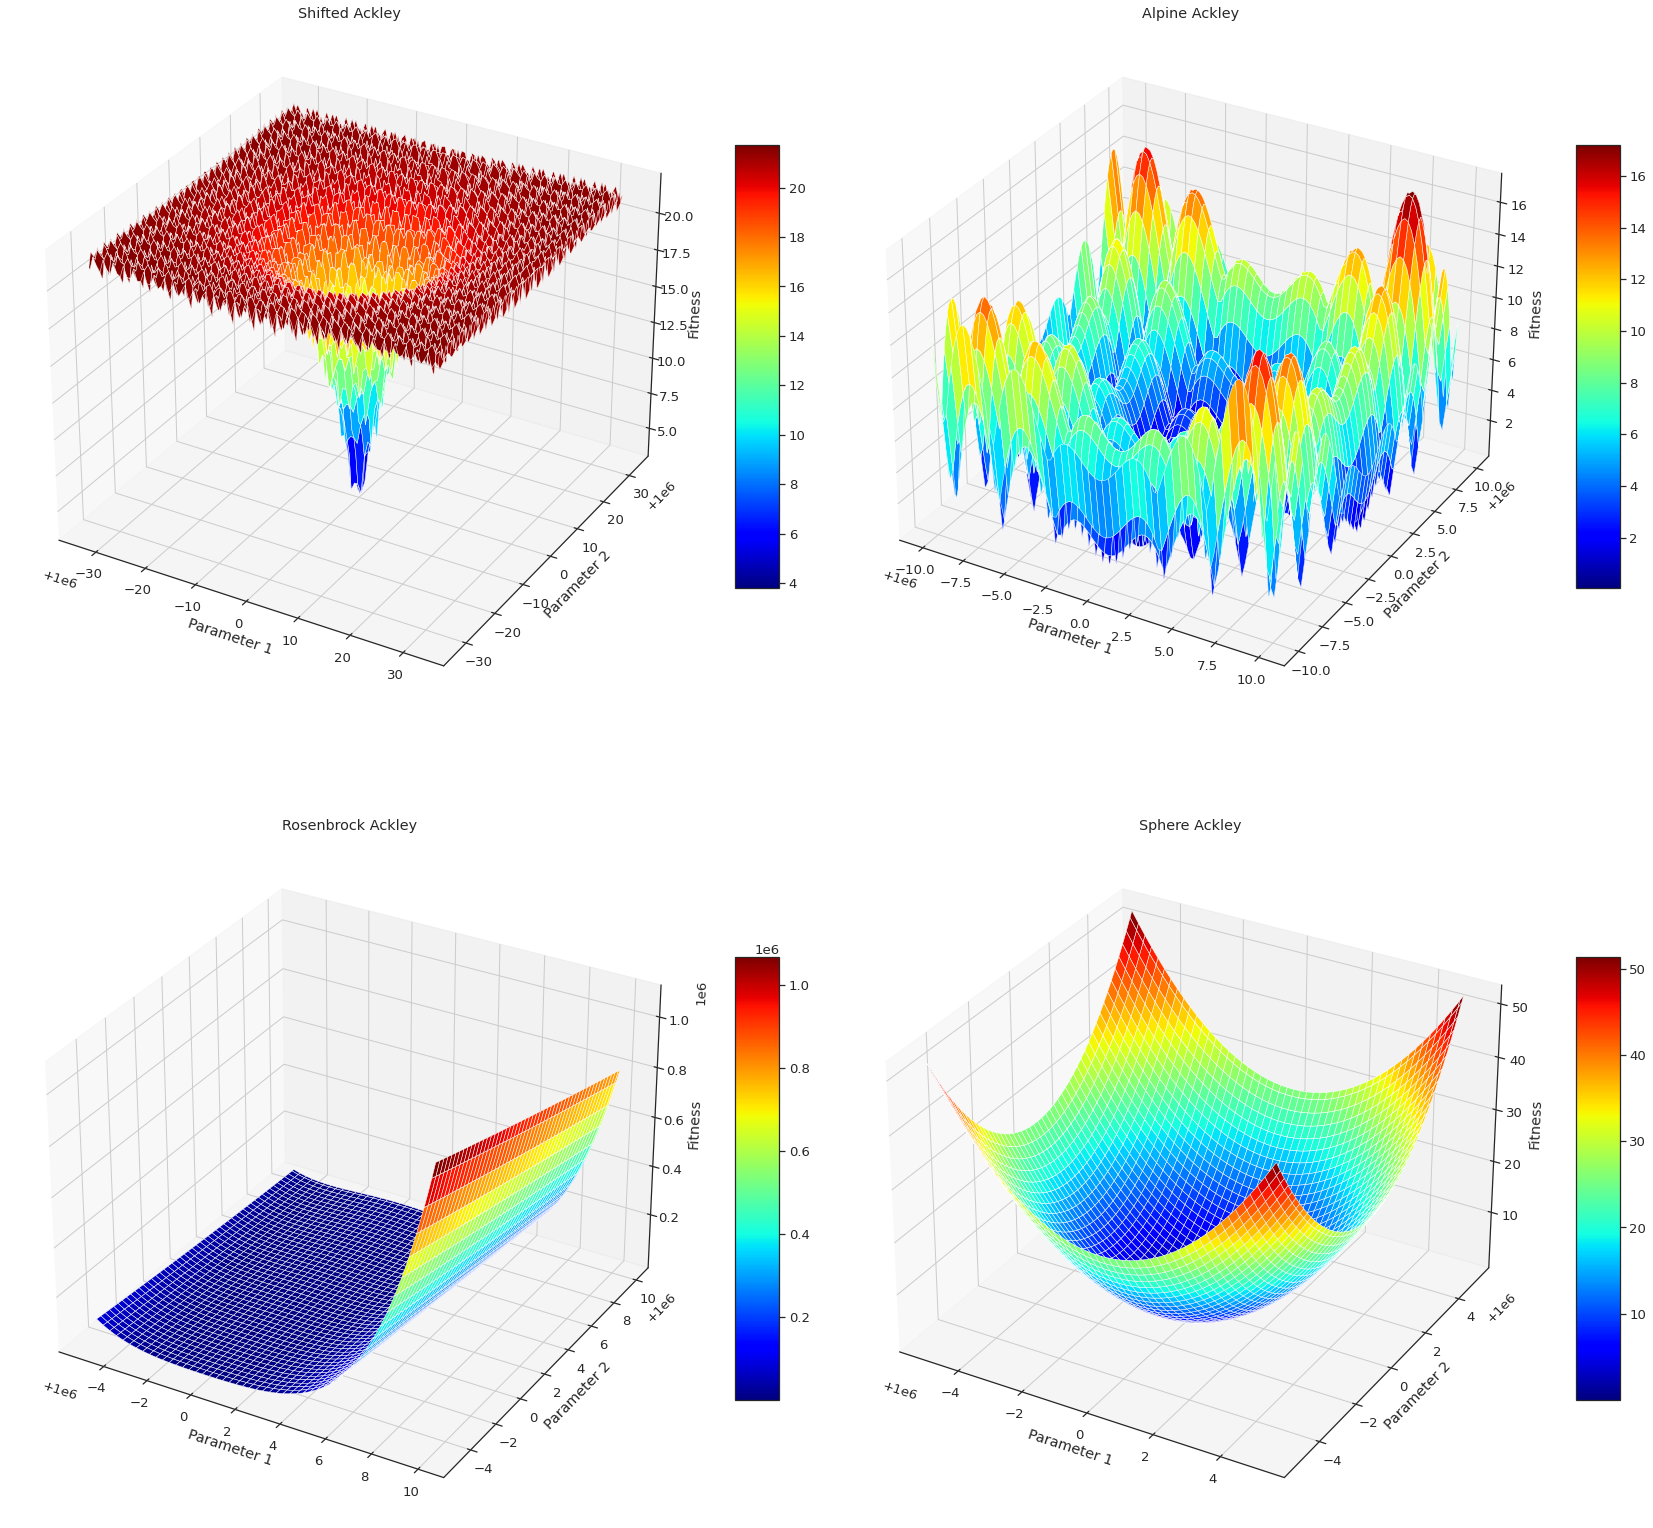

In [5]:
sns.set(font_scale=1.2)
sns.set_style("white")
fig = plt.figure(figsize=(24,24))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

# ****************************************************** Ackley *******************************************************
bounds = Boundaries("Ackley_shifted")
x      = y = np.linspace(bounds[0], bounds[1], 100)
X, Y   = np.meshgrid(x, y)

zs = np.array([Ackley_shifted(list([x,y])) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z  = zs.reshape(X.shape)

surf = ax1.plot_surface(X, Y, Z, cmap=cm.jet, linewidth=.5, antialiased=True)

ax1.set_xlabel('Parameter 1')
ax1.set_ylabel('Parameter 2')
ax1.set_zlabel('Fitness')
ax1.set_title('Shifted Ackley')

fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)


# ****************************************************** Alpine *******************************************************
bounds = Boundaries("Alpine_shifted")
x      = y = np.linspace(bounds[0], bounds[1], 100)
X, Y   = np.meshgrid(x, y)

zs = np.array([Alpine_shifted(list([x,y])) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z  = zs.reshape(X.shape)

surf = ax2.plot_surface(X, Y, Z, cmap=cm.jet, linewidth=.5, antialiased=True)

ax2.set_xlabel('Parameter 1')
ax2.set_ylabel('Parameter 2')
ax2.set_zlabel('Fitness')
ax2.set_title('Alpine Ackley')

fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=10)


# **************************************************** Rosenbrock *****************************************************
bounds = Boundaries("Rosenbrock_shifted")
x      = y = np.linspace(bounds[0], bounds[1], 100)
X, Y   = np.meshgrid(x, y)

zs = np.array([Rosenbrock_shifted(list([x,y])) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z  = zs.reshape(X.shape)

surf = ax3.plot_surface(X, Y, Z, cmap=cm.jet, linewidth=.5, antialiased=True)

ax3.set_xlabel('Parameter 1')
ax3.set_ylabel('Parameter 2')
ax3.set_zlabel('Fitness')
ax3.set_title('Rosenbrock Ackley')

fig.colorbar(surf, ax=ax3, shrink=0.5, aspect=10)


# ****************************************************** Sphere *******************************************************
bounds = Boundaries("Sphere_shifted")
x      = y = np.linspace(bounds[0], bounds[1], 100)
X, Y   = np.meshgrid(x, y)

zs = np.array([Sphere_shifted(list([x,y])) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z  = zs.reshape(X.shape)

surf = ax4.plot_surface(X, Y, Z, cmap=cm.jet, linewidth=.5, antialiased=True)

ax4.set_xlabel('Parameter 1')
ax4.set_ylabel('Parameter 2')
ax4.set_zlabel('Fitness')
ax4.set_title('Sphere Ackley')

fig.colorbar(surf, ax=ax4, shrink=0.5, aspect=10)
fig.tight_layout()

plt.show()

In [6]:
repetitions = 30

path_random     = "Results/RandomSearch/Ackley_shifted_2/" 
path_sso        = "Results/SSO/Ackley_shifted_2/" 
path_sso_code   = "Results/SSO_code/Ackley_shifted_2/" 
path_asso_code  = "Results/ASSO/Ackley_shifted_2/" 

comparison_Ackley = {}
comparison_Ackley["Random"]   = []
comparison_Ackley["SSO"]      = []
comparison_Ackley["SSO-code"] = []
comparison_Ackley["ASSO"]     = []

ABF_Ackley = np.zeros((100, 5))
for r in range(repetitions):
    ABF_Ackley[:, 0] += np.loadtxt(path_random+"random_rep%d_fitness"%r)
    ABF_Ackley[:, 1] += np.loadtxt(path_sso+"sso_rep%d_fitness"%r)
    ABF_Ackley[:, 2] += np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)
    ABF_Ackley[:, 3] += np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)
    comparison_Ackley["Random"].append((np.loadtxt(path_random+"random_rep%d_fitness"%r))[-1])
    comparison_Ackley["SSO"].append((np.loadtxt(path_sso+"sso_rep%d_fitness"%r)[-1]))
    comparison_Ackley["SSO-code"].append((np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r))[-1])
    comparison_Ackley["ASSO"].append((np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r))[-1])

ABF_Ackley /= repetitions

STD_Ackley = np.zeros((100, 5))
for r in range(repetitions):
    STD_Ackley[:, 0] += (np.loadtxt(path_random+"random_rep%d_fitness"%r)       - ABF_Ackley[:, 0])**2
    STD_Ackley[:, 1] += (np.loadtxt(path_sso+"sso_rep%d_fitness"%r)             - ABF_Ackley[:, 1])**2
    STD_Ackley[:, 2] += (np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)   - ABF_Ackley[:, 2])**2
    STD_Ackley[:, 3] += (np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)      - ABF_Ackley[:, 3])**2

STD_Ackley /= repetitions
STD_Ackley = np.sqrt(STD_Ackley)

In [7]:
repetitions = 30

path_random     = "Results/RandomSearch/Alpine_shifted_2/" 
path_sso        = "Results/SSO/Alpine_shifted_2/" 
path_sso_code   = "Results/SSO_code/Alpine_shifted_2/" 
path_asso_code  = "Results/ASSO/Alpine_shifted_2/" 

comparison_Alpine = {}
comparison_Alpine["Random"]   = []
comparison_Alpine["SSO"]      = []
comparison_Alpine["SSO-code"] = []
comparison_Alpine["ASSO"]     = []

ABF_Alpine = np.zeros((100, 5))
for r in range(repetitions):
    ABF_Alpine[:, 0] += np.loadtxt(path_random+"random_rep%d_fitness"%r)
    ABF_Alpine[:, 1] += np.loadtxt(path_sso+"sso_rep%d_fitness"%r)
    ABF_Alpine[:, 2] += np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)
    ABF_Alpine[:, 3] += np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)
    comparison_Alpine["Random"].append((np.loadtxt(path_random+"random_rep%d_fitness"%r))[-1])
    comparison_Alpine["SSO"].append((np.loadtxt(path_sso+"sso_rep%d_fitness"%r)[-1]))
    comparison_Alpine["SSO-code"].append((np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r))[-1])
    comparison_Alpine["ASSO"].append((np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r))[-1])

ABF_Alpine /= repetitions

STD_Alpine = np.zeros((100, 5))
for r in range(repetitions):
    STD_Alpine[:, 0] += (np.loadtxt(path_random+"random_rep%d_fitness"%r)       - ABF_Alpine[:, 0])**2
    STD_Alpine[:, 1] += (np.loadtxt(path_sso+"sso_rep%d_fitness"%r)             - ABF_Alpine[:, 1])**2
    STD_Alpine[:, 2] += (np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)   - ABF_Alpine[:, 2])**2
    STD_Alpine[:, 3] += (np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)      - ABF_Alpine[:, 3])**2

STD_Alpine /= repetitions
STD_Alpine = np.sqrt(STD_Alpine)

In [8]:
repetitions = 30

path_random     = "Results/RandomSearch/Rosenbrock_shifted_2/" 
path_sso        = "Results/SSO/Rosenbrock_shifted_2/" 
path_sso_code   = "Results/SSO_code/Rosenbrock_shifted_2/" 
path_asso_code  = "Results/ASSO/Rosenbrock_shifted_2/" 

comparison_Rosenbrock = {}
comparison_Rosenbrock["Random"]   = []
comparison_Rosenbrock["SSO"]      = []
comparison_Rosenbrock["SSO-code"] = []
comparison_Rosenbrock["ASSO"]     = []

ABF_Rosenbrock = np.zeros((100, 5))
for r in range(repetitions):
    ABF_Rosenbrock[:, 0] += np.loadtxt(path_random+"random_rep%d_fitness"%r)
    ABF_Rosenbrock[:, 1] += np.loadtxt(path_sso+"sso_rep%d_fitness"%r)
    ABF_Rosenbrock[:, 2] += np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)
    ABF_Rosenbrock[:, 3] += np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)
    comparison_Rosenbrock["Random"].append((np.loadtxt(path_random+"random_rep%d_fitness"%r))[-1])
    comparison_Rosenbrock["SSO"].append((np.loadtxt(path_sso+"sso_rep%d_fitness"%r)[-1]))
    comparison_Rosenbrock["SSO-code"].append((np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r))[-1])
    comparison_Rosenbrock["ASSO"].append((np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r))[-1])

ABF_Rosenbrock /= repetitions

STD_Rosenbrock = np.zeros((100, 5))
for r in range(repetitions):
    STD_Rosenbrock[:, 0] += (np.loadtxt(path_random+"random_rep%d_fitness"%r)       - ABF_Rosenbrock[:, 0])**2
    STD_Rosenbrock[:, 1] += (np.loadtxt(path_sso+"sso_rep%d_fitness"%r)             - ABF_Rosenbrock[:, 1])**2
    STD_Rosenbrock[:, 2] += (np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)   - ABF_Rosenbrock[:, 2])**2
    STD_Rosenbrock[:, 3] += (np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)      - ABF_Rosenbrock[:, 3])**2

STD_Rosenbrock /= repetitions
STD_Rosenbrock = np.sqrt(STD_Rosenbrock)

In [9]:
repetitions = 30

path_random     = "Results/RandomSearch/Sphere_shifted_2/" 
path_sso        = "Results/SSO/Sphere_shifted_2/" 
path_sso_code   = "Results/SSO_code/Sphere_shifted_2/" 
path_asso_code  = "Results/ASSO/Sphere_shifted_2/" 

comparison_Sphere = {}
comparison_Sphere["Random"]   = []
comparison_Sphere["SSO"]      = []
comparison_Sphere["SSO-code"] = []
comparison_Sphere["ASSO"]     = []

ABF_Sphere = np.zeros((100, 5))
for r in range(repetitions):
    ABF_Sphere[:, 0] += np.loadtxt(path_random+"random_rep%d_fitness"%r)
    ABF_Sphere[:, 1] += np.loadtxt(path_sso+"sso_rep%d_fitness"%r)
    ABF_Sphere[:, 2] += np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)
    ABF_Sphere[:, 3] += np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)
    comparison_Sphere["Random"].append((np.loadtxt(path_random+"random_rep%d_fitness"%r))[-1])
    comparison_Sphere["SSO"].append((np.loadtxt(path_sso+"sso_rep%d_fitness"%r)[-1]))
    comparison_Sphere["SSO-code"].append((np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r))[-1])
    comparison_Sphere["ASSO"].append((np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r))[-1])

ABF_Sphere /= repetitions

STD_Sphere = np.zeros((100, 5))
for r in range(repetitions):
    STD_Sphere[:, 0] += (np.loadtxt(path_random+"random_rep%d_fitness"%r)       - ABF_Sphere[:, 0])**2
    STD_Sphere[:, 1] += (np.loadtxt(path_sso+"sso_rep%d_fitness"%r)             - ABF_Sphere[:, 1])**2
    STD_Sphere[:, 2] += (np.loadtxt(path_sso_code+"sso_code_rep%d_fitness"%r)   - ABF_Sphere[:, 2])**2
    STD_Sphere[:, 3] += (np.loadtxt(path_asso_code+"asso_rep%d_fitness"%r)      - ABF_Sphere[:, 3])**2

STD_Sphere /= repetitions
STD_Sphere = np.sqrt(STD_Sphere)

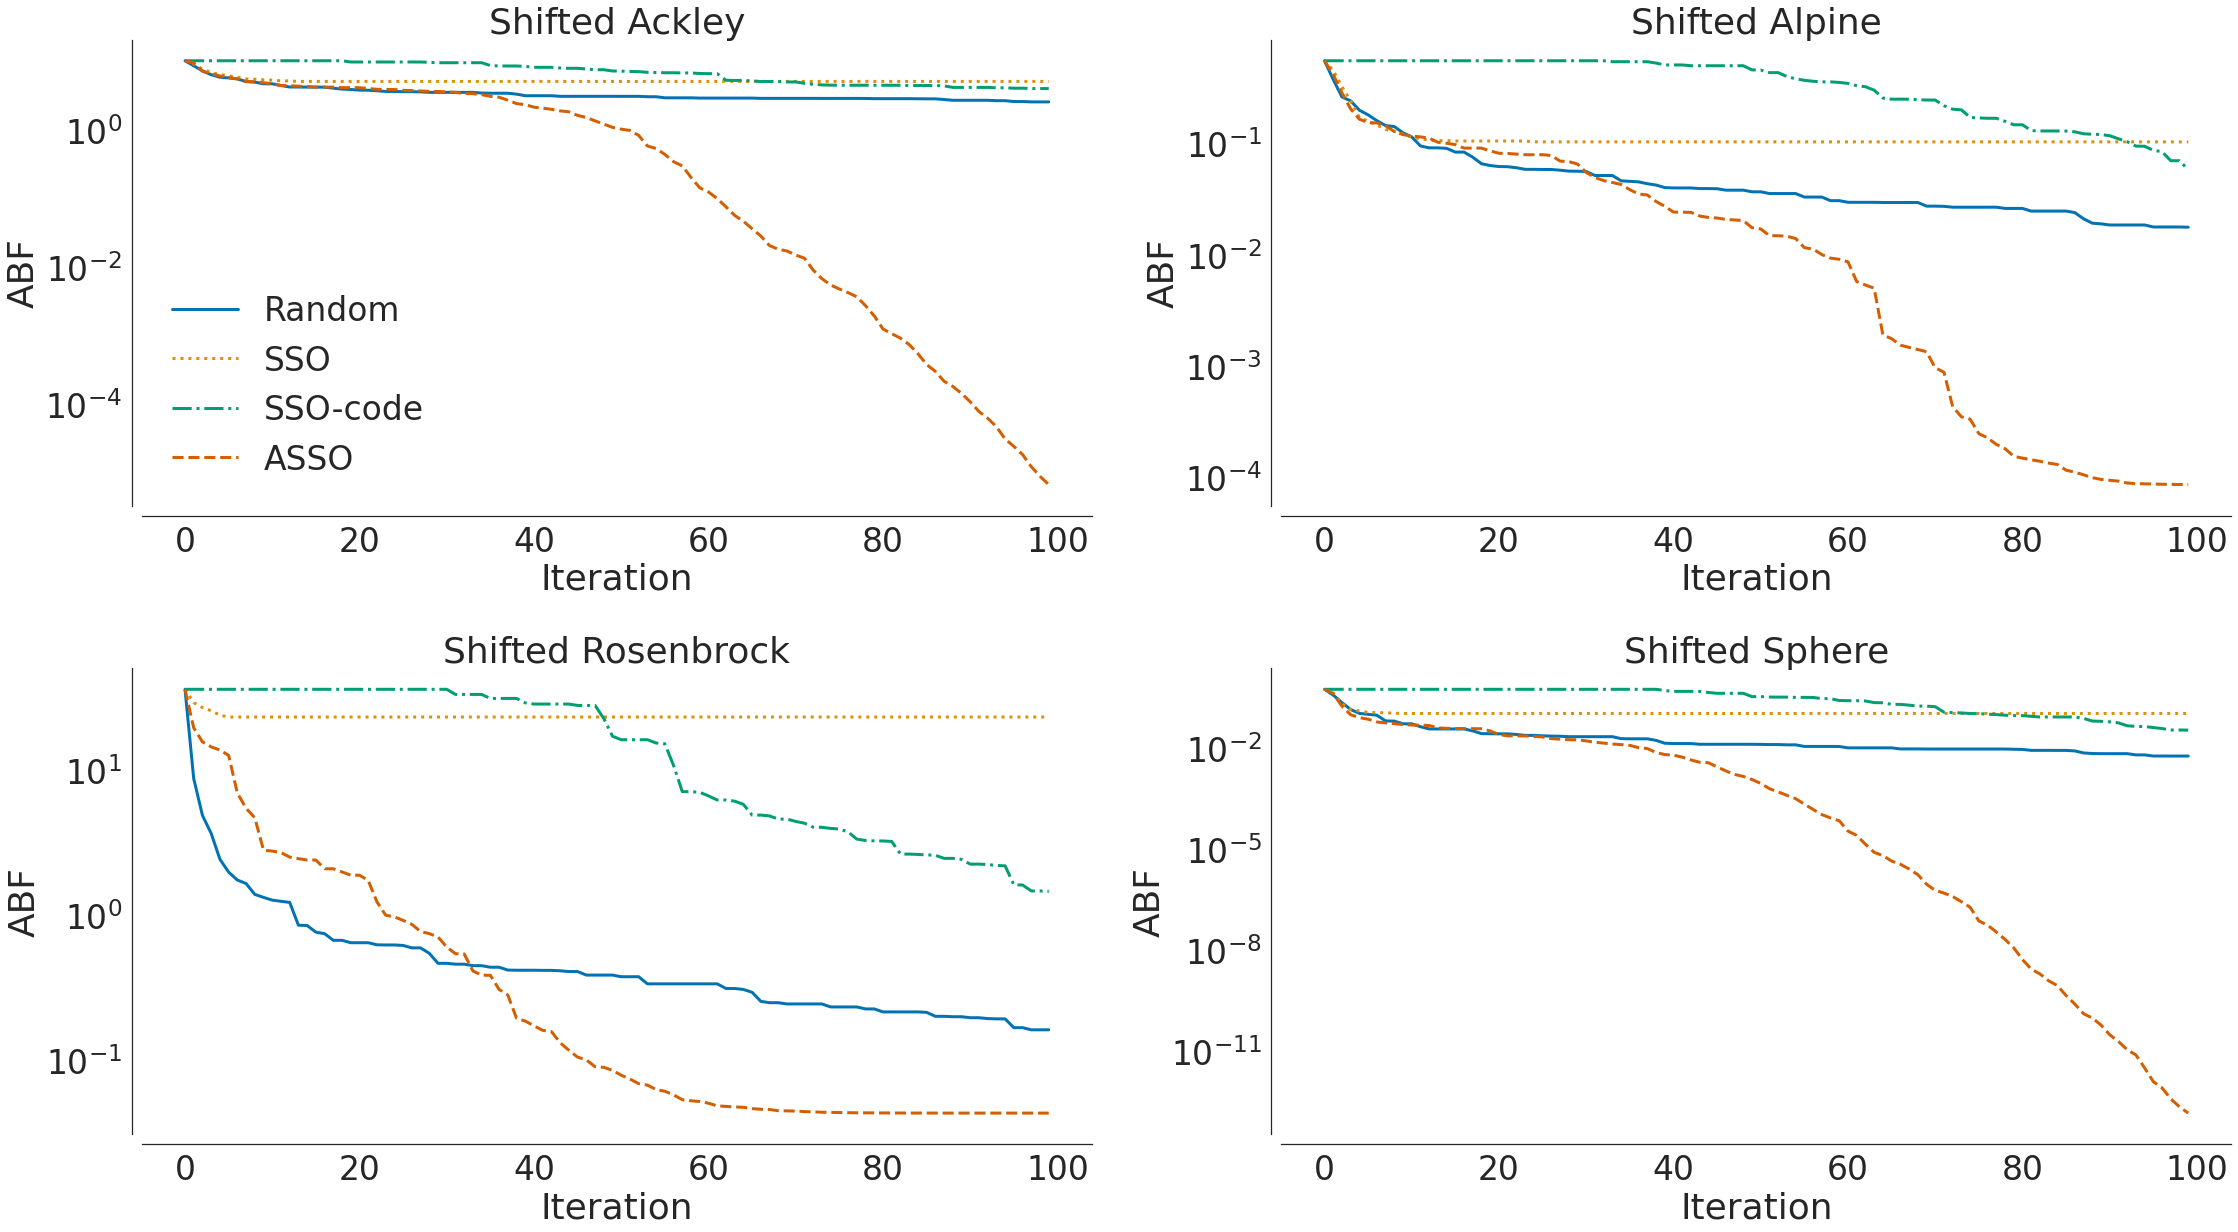

In [10]:
iterations = list(range(100))
palette    = sns.color_palette("colorblind")

sns.set(font_scale=3)
sns.set_style("white")
fig = plt.figure(figsize=(32,18))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.despine(offset=10, trim=False)


# ****************************************************** Ackley *******************************************************
ax1.plot(iterations, ABF_Ackley[:,0], label="Random",   linewidth=3, color=palette[0], linestyle="-")
ax1.plot(iterations, ABF_Ackley[:,1], label="SSO",      linewidth=3, color=palette[1], linestyle=":")
ax1.plot(iterations, ABF_Ackley[:,2], label="SSO-code", linewidth=3, color=palette[2], linestyle="-.")
ax1.plot(iterations, ABF_Ackley[:,3], label="ASSO",     linewidth=3, color=palette[3], linestyle="--")

#ax1.fill_between(iterations, ABF_Ackley[:,0] - STD_Ackley[:,0], ABF_Ackley[:,0] + STD_Ackley[:,0], color=palette[0], alpha=0.2)
#ax1.fill_between(iterations, ABF_Ackley[:,1] - STD_Ackley[:,1], ABF_Ackley[:,1] + STD_Ackley[:,1], color=palette[1], alpha=0.2)
#ax1.fill_between(iterations, ABF_Ackley[:,2] - STD_Ackley[:,2], ABF_Ackley[:,2] + STD_Ackley[:,2], color=palette[2], alpha=0.2)
#ax1.fill_between(iterations, ABF_Ackley[:,3] - STD_Ackley[:,3], ABF_Ackley[:,3] + STD_Ackley[:,3], color=palette[3], alpha=0.2)

ax1.set_yscale('log')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('ABF')
ax1.set_title('Shifted Ackley')

ax1.legend(frameon=False)


# ****************************************************** Alpine *******************************************************
ax2.plot(iterations, ABF_Alpine[:,0], linewidth=3, color=palette[0], linestyle="-")
ax2.plot(iterations, ABF_Alpine[:,1], linewidth=3, color=palette[1], linestyle=":")
ax2.plot(iterations, ABF_Alpine[:,2], linewidth=3, color=palette[2], linestyle="-.")
ax2.plot(iterations, ABF_Alpine[:,3], linewidth=3, color=palette[3], linestyle="--")

#ax2.fill_between(iterations, ABF_Alpine[:,0] - STD_Alpine[:,0], ABF_Alpine[:,0] + STD_Alpine[:,0], color=palette[0], alpha=0.2)
#ax2.fill_between(iterations, ABF_Alpine[:,1] - STD_Alpine[:,1], ABF_Alpine[:,1] + STD_Alpine[:,1], color=palette[1], alpha=0.2)
#ax2.fill_between(iterations, ABF_Alpine[:,2] - STD_Alpine[:,2], ABF_Alpine[:,2] + STD_Alpine[:,2], color=palette[2], alpha=0.2)
#ax2.fill_between(iterations, ABF_Alpine[:,3] - STD_Alpine[:,3], ABF_Alpine[:,3] + STD_Alpine[:,3], color=palette[3], alpha=0.2)

ax2.set_yscale('log')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('ABF')
ax2.set_title('Shifted Alpine')


# **************************************************** Rosenbrock *****************************************************
ax3.plot(iterations, ABF_Rosenbrock[:,0], linewidth=3, color=palette[0], linestyle="-")
ax3.plot(iterations, ABF_Rosenbrock[:,1], linewidth=3, color=palette[1], linestyle=":")
ax3.plot(iterations, ABF_Rosenbrock[:,2], linewidth=3, color=palette[2], linestyle="-.")
ax3.plot(iterations, ABF_Rosenbrock[:,3], linewidth=3, color=palette[3], linestyle="--")

#ax3.fill_between(iterations, ABF_Rosenbrock[:,0] - STD_Rosenbrock[:,0], ABF_Rosenbrock[:,0] + STD_Rosenbrock[:,0], color=palette[0], alpha=0.2)
#ax3.fill_between(iterations, ABF_Rosenbrock[:,1] - STD_Rosenbrock[:,1], ABF_Rosenbrock[:,1] + STD_Rosenbrock[:,1], color=palette[1], alpha=0.2)
#ax3.fill_between(iterations, ABF_Rosenbrock[:,2] - STD_Rosenbrock[:,2], ABF_Rosenbrock[:,2] + STD_Rosenbrock[:,2], color=palette[2], alpha=0.2)
#ax3.fill_between(iterations, ABF_Rosenbrock[:,3] - STD_Rosenbrock[:,3], ABF_Rosenbrock[:,3] + STD_Rosenbrock[:,3], color=palette[3], alpha=0.2)

ax3.set_yscale('log')

ax3.set_xlabel('Iteration')
ax3.set_ylabel('ABF')
ax3.set_title('Shifted Rosenbrock')


# ****************************************************** Sphere *******************************************************
ax4.plot(iterations, ABF_Sphere[:,0], linewidth=3, color=palette[0], linestyle="-")
ax4.plot(iterations, ABF_Sphere[:,1], linewidth=3, color=palette[1], linestyle=":")
ax4.plot(iterations, ABF_Sphere[:,2], linewidth=3, color=palette[2], linestyle="-.")
ax4.plot(iterations, ABF_Sphere[:,3], linewidth=3, color=palette[3], linestyle="--")

#ax4.fill_between(iterations, ABF_Sphere[:,0] - STD_Sphere[:,0], ABF_Sphere[:,0] + STD_Sphere[:,0], color=palette[0], alpha=0.2)
#ax4.fill_between(iterations, ABF_Sphere[:,1] - STD_Sphere[:,1], ABF_Sphere[:,1] + STD_Sphere[:,1], color=palette[1], alpha=0.2)
#ax4.fill_between(iterations, ABF_Sphere[:,2] - STD_Sphere[:,2], ABF_Sphere[:,2] + STD_Sphere[:,2], color=palette[2], alpha=0.2)
#ax4.fill_between(iterations, ABF_Sphere[:,3] - STD_Sphere[:,3], ABF_Sphere[:,3] + STD_Sphere[:,3], color=palette[3], alpha=0.2)

ax4.set_yscale('log')

ax4.set_xlabel('Iteration')
ax4.set_ylabel('ABF')
ax4.set_title('Shifted Sphere')

plt.tight_layout()
#plt.savefig("ABFs.pdf")

# Comparisons

In [11]:
# ****************************************************** Ackley *******************************************************
data = comparison_Ackley["Random"] + comparison_Ackley["SSO"] + comparison_Ackley["SSO-code"] + comparison_Ackley["ASSO"]

df_Ackley = pd.DataFrame(data = data, columns=["Fitness"])
df_Ackley["Method"] = ["Random"]*30 + ["SSO"]*30 + ["SSO-code"]*30 + ["ASSO"]*30
df_Ackley['Method'] = pd.Categorical(df_Ackley['Method'], categories=["Random", "SSO", "SSO-code", "ASSO"], ordered=False)

kwargs = {}
kwargs["alternative"] = 'two-sided'
comparison_Ackley = multipleComparisons(df_Ackley,
                                        group_by     = "Method",
                                        data         = "Fitness",
                                        min_elements = 15,
                                        **kwargs)


# ****************************************************** Alpine *******************************************************
data = comparison_Alpine["Random"] + comparison_Alpine["SSO"] + comparison_Alpine["SSO-code"] + comparison_Alpine["ASSO"]

df_Alpine = pd.DataFrame(data = data, columns=["Fitness"])
df_Alpine["Method"] = ["Random"]*30 + ["SSO"]*30 + ["SSO-code"]*30 + ["ASSO"]*30
df_Alpine['Method'] = pd.Categorical(df_Alpine['Method'], categories=["Random", "SSO", "SSO-code", "ASSO"], ordered=False)

kwargs = {}
kwargs["alternative"] = 'two-sided'
comparison_Alpine = multipleComparisons(df_Alpine,
                                        group_by     = "Method",
                                        data         = "Fitness",
                                        min_elements = 15,
                                        **kwargs)


# **************************************************** Rosenbrock *****************************************************
data = comparison_Rosenbrock["Random"] + comparison_Rosenbrock["SSO"] + comparison_Rosenbrock["SSO-code"] + comparison_Rosenbrock["ASSO"]

df_Rosenbrock = pd.DataFrame(data = data, columns=["Fitness"])
df_Rosenbrock["Method"] = ["Random"]*30 + ["SSO"]*30 + ["SSO-code"]*30 + ["ASSO"]*30
df_Rosenbrock['Method'] = pd.Categorical(df_Rosenbrock['Method'], categories=["Random", "SSO", "SSO-code", "ASSO"], ordered=False)

kwargs = {}
kwargs["alternative"] = 'two-sided'
comparison_Rosenbrock = multipleComparisons(df_Rosenbrock,
                                        group_by     = "Method",
                                        data         = "Fitness",
                                        min_elements = 15,
                                        **kwargs)


# ****************************************************** Sphere *******************************************************
data = comparison_Sphere["Random"] + comparison_Sphere["SSO"] + comparison_Sphere["SSO-code"] + comparison_Sphere["ASSO"]

df_Sphere = pd.DataFrame(data = data, columns=["Fitness"])
df_Sphere["Method"] = ["Random"]*30 + ["SSO"]*30 + ["SSO-code"]*30 + ["ASSO"]*30
df_Sphere['Method'] = pd.Categorical(df_Sphere['Method'], categories=["Random", "SSO", "SSO-code", "ASSO"], ordered=False)

kwargs = {}
kwargs["alternative"] = 'two-sided'
comparison_Sphere = multipleComparisons(df_Sphere,
                                        group_by     = "Method",
                                        data         = "Fitness",
                                        min_elements = 15,
                                        **kwargs)

* Running 'Mann–Whitney U test' ('scipy.stats.mannwhitneyu')
* Running 'Mann–Whitney U test' ('scipy.stats.mannwhitneyu')
* Running 'Mann–Whitney U test' ('scipy.stats.mannwhitneyu')
* Running 'Mann–Whitney U test' ('scipy.stats.mannwhitneyu')


In [12]:
comparison_Ackley

Group 1   Group 2   p-value  corrected p-value
0    Random       SSO  0.000125       7.486232e-04
1    Random  SSO-code   0.00168       1.007853e-02
2    Random      ASSO       0.0       1.810780e-10
3       SSO  SSO-code  0.206205       1.000000e+00
4       SSO      ASSO       0.0       1.810780e-10
5  SSO-code      ASSO       0.0       1.810780e-10

In [13]:
comparison_Alpine

Group 1   Group 2   p-value  corrected p-value
0    Random       SSO  0.000019       1.120901e-04
1    Random  SSO-code  0.010315       6.188803e-02
2    Random      ASSO       0.0       1.811916e-10
3       SSO  SSO-code  0.048413       2.904810e-01
4       SSO      ASSO       0.0       1.811916e-10
5  SSO-code      ASSO       0.0       1.811916e-10

In [14]:
comparison_Rosenbrock

Group 1   Group 2   p-value  corrected p-value
0    Random       SSO       0.0       2.213836e-10
1    Random  SSO-code  0.000006       3.769680e-05
2    Random      ASSO       0.0       6.062720e-08
3       SSO  SSO-code   0.00006       3.582334e-04
4       SSO      ASSO       0.0       2.446299e-10
5  SSO-code      ASSO       0.0       1.565912e-09

In [15]:
comparison_Sphere

Group 1   Group 2   p-value  corrected p-value
0    Random       SSO   0.00001       5.708363e-05
1    Random  SSO-code  0.176128       1.000000e+00
2    Random      ASSO       0.0       1.739442e-10
3       SSO  SSO-code  0.014709       8.825439e-02
4       SSO      ASSO       0.0       1.739442e-10
5  SSO-code      ASSO       0.0       1.739442e-10

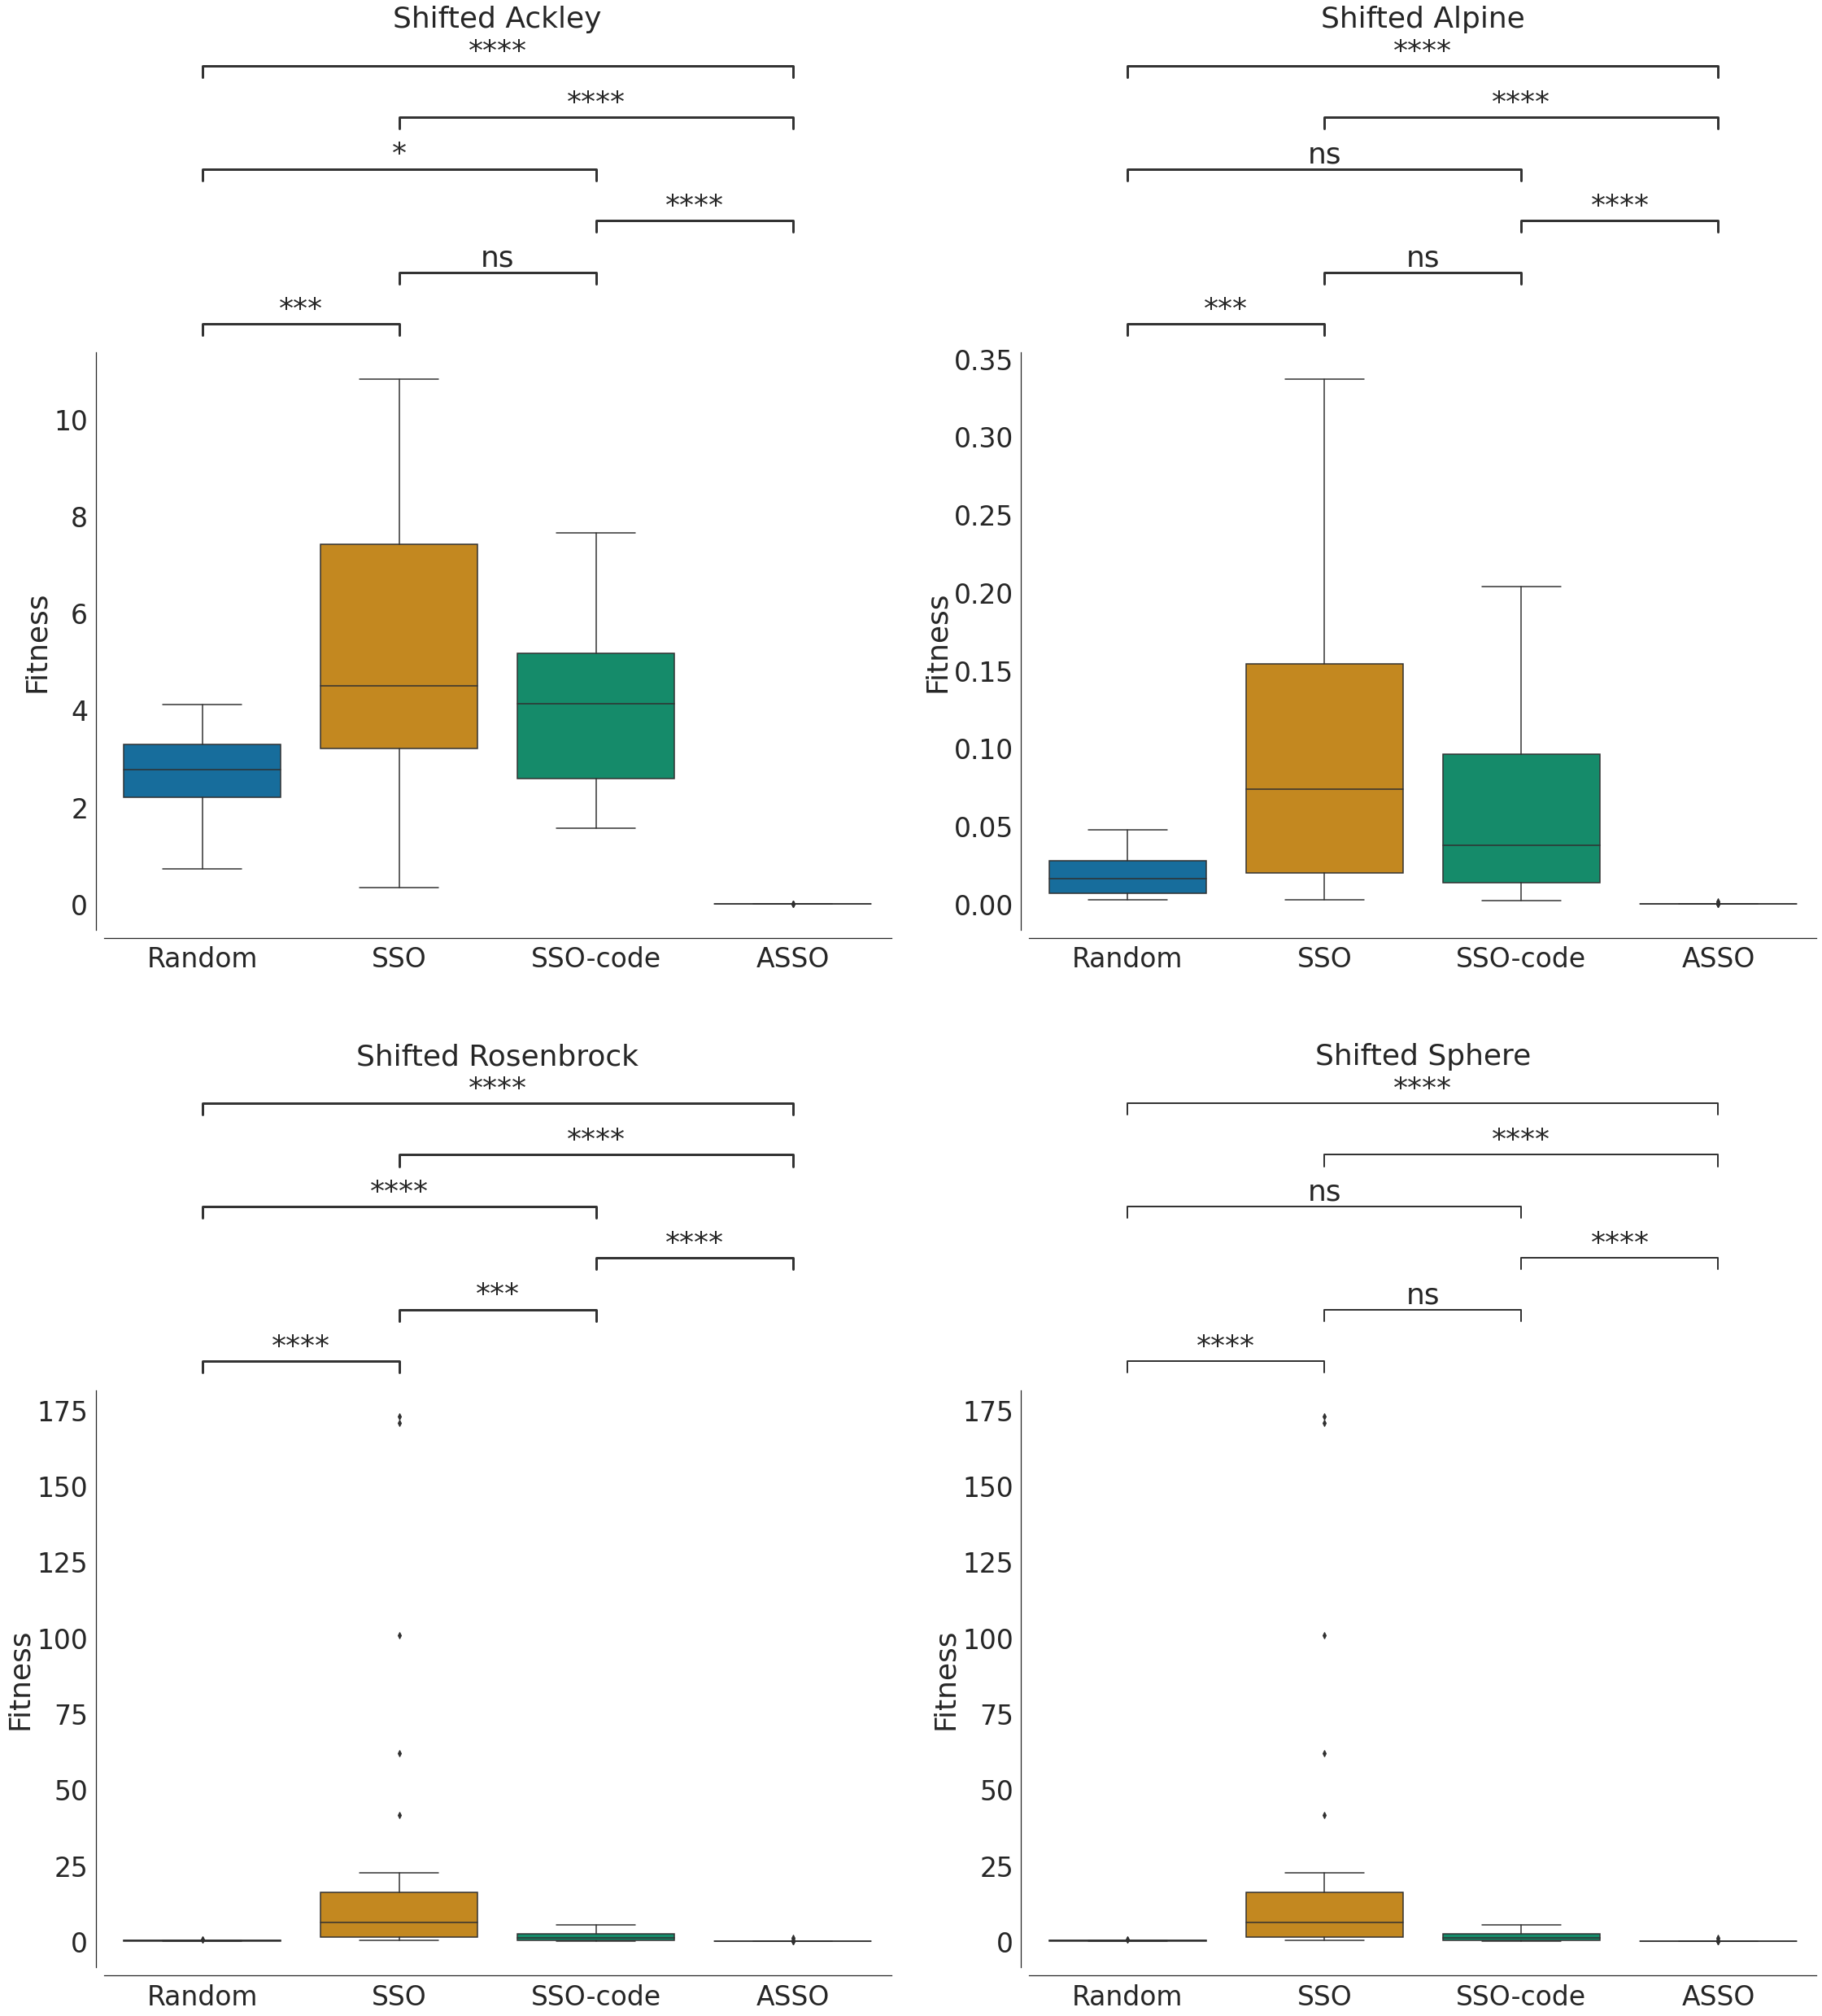

In [16]:
palette    = sns.color_palette("colorblind")

sns.set(font_scale=3)
sns.set_style("white")
fig = plt.figure(figsize=(32,36))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.despine(offset=10, trim=False)

# ****************************************************** Ackley *******************************************************
ax1 = sns.boxplot(x="Method", y="Fitness", data=df_Ackley, ax=ax1, palette=palette)

stats_results = add_stat_annotation(ax1,
                                    data              = df_Ackley,
                                    x                 = "Method",
                                    y                 = "Fitness",
                                    perform_stat_test = False,
                                    box_pairs         = comparison_Ackley[["Group 1", "Group 2"]].values.tolist(),
                                    pvalues           = comparison_Ackley["corrected p-value"].values.tolist(),
                                    test              = None,
                                    text_format       = 'star',
                                    loc               = 'outside',
                                    line_height       = 0.02,
                                    linewidth         = 3,
                                    fontsize          = 36,
                                    verbose           = 0)

plt.setp(ax1.get_xticklabels(), rotation=0)

#ax1.set_xlabel("Shifted Ackley")
ax1.set_xlabel("")
ax1.set_ylabel("Fitness")
ax1.set_title("Shifted Ackley", pad=400)


# ****************************************************** Alpine *******************************************************
ax2 = sns.boxplot(x="Method", y="Fitness", data=df_Alpine, ax=ax2, palette=palette)

stats_results = add_stat_annotation(ax2,
                                    data              = df_Alpine,
                                    x                 = "Method",
                                    y                 = "Fitness",
                                    perform_stat_test = False,
                                    box_pairs         = comparison_Alpine[["Group 1", "Group 2"]].values.tolist(),
                                    pvalues           = comparison_Alpine["corrected p-value"].values.tolist(),
                                    test              = None,
                                    text_format       = 'star',
                                    loc               = 'outside',
                                    line_height       = 0.02,
                                    linewidth         = 3,
                                    fontsize          = 36,
                                    verbose           = 0)

plt.setp(ax2.get_xticklabels(), rotation=0)

#ax2.set_xlabel("Shifted Alpine")
ax2.set_xlabel("")
ax2.set_ylabel("Fitness")
ax2.set_title("Shifted Alpine", pad=400)


# **************************************************** Rosenbrock *****************************************************
ax3 = sns.boxplot(x="Method", y="Fitness", data=df_Rosenbrock, ax=ax3, palette=palette)

stats_results = add_stat_annotation(ax3,
                                    data              = df_Rosenbrock,
                                    x                 = "Method",
                                    y                 = "Fitness",
                                    perform_stat_test = False,
                                    box_pairs         = comparison_Rosenbrock[["Group 1", "Group 2"]].values.tolist(),
                                    pvalues           = comparison_Rosenbrock["corrected p-value"].values.tolist(),
                                    test              = None,
                                    text_format       = 'star',
                                    loc               = 'outside',
                                    line_height       = 0.02,
                                    linewidth         = 3,
                                    fontsize          = 36,
                                    verbose           = 0)

plt.setp(ax3.get_xticklabels(), rotation=0)

#ax3.set_xlabel("Shifted Rosenbrock")
ax3.set_xlabel("")
ax3.set_ylabel("Fitness")
ax3.set_title("Shifted Rosenbrock", pad=400)


# ****************************************************** Sphere *******************************************************
ax4 = sns.boxplot(x="Method", y="Fitness", data=df_Rosenbrock, ax=ax4, palette=palette)

stats_results = add_stat_annotation(ax4,
                                    data              = df_Sphere,
                                    x                 = "Method",
                                    y                 = "Fitness",
                                    perform_stat_test = False,
                                    box_pairs         = comparison_Sphere[["Group 1", "Group 2"]].values.tolist(),
                                    pvalues           = comparison_Sphere["corrected p-value"].values.tolist(),
                                    test              = None,
                                    text_format       = 'star',
                                    loc               = 'outside',
                                    line_height       = 0.02,
                                    linewidth         = 2,
                                    #fontsize          = 36,
                                    verbose           = 0)

plt.setp(ax4.get_xticklabels(), rotation=0)

#ax4.set_xlabel("Shifted Sphere")
ax4.set_xlabel("")
ax4.set_ylabel("Fitness")
ax4.set_title("Shifted Sphere", pad=400)

fig.tight_layout(h_pad=1)
#plt.savefig("Boxplots.pdf") 